# Aygaz Data Processing Bootcamp


# 0. Preparation of the Dataset

In [1]:
# Installing the Required Libraries:

import pandas as pd
import seaborn as sb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import calendar
from sklearn.compose import make_column_selector
import warnings
import missingno as msno
from matplotlib import cm
warnings.filterwarnings('ignore')

In [2]:
# Reading the Dataset:

data = pd.read_csv("/kaggle/input/online-shopping-dataset/file.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52955 entries, 0 to 52954
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           52955 non-null  int64  
 1   CustomerID           52924 non-null  float64
 2   Gender               52924 non-null  object 
 3   Location             52924 non-null  object 
 4   Tenure_Months        52924 non-null  float64
 5   Transaction_ID       52924 non-null  float64
 6   Transaction_Date     52924 non-null  object 
 7   Product_SKU          52924 non-null  object 
 8   Product_Description  52924 non-null  object 
 9   Product_Category     52955 non-null  object 
 10  Quantity             52924 non-null  float64
 11  Avg_Price            52924 non-null  float64
 12  Delivery_Charges     52924 non-null  float64
 13  Coupon_Status        52924 non-null  object 
 14  GST                  52924 non-null  float64
 15  Date                 52924 non-null 

In [3]:
# Let's create random missing data in the dataset:

import random

def add_random_missing_values(dataframe: pd.DataFrame,
                              missing_rate: float = 0.05,
                              seed: random = 42) -> pd.DataFrame:
    """Turns random values to NaN in a DataFrame.
    
    To use this function, you need to import pandas, numpy and random libraries.

    Args:
        dataframe (pd.DataFrame): DataFrame to be processed.
        missing_rate (float): Percentage of missing value rate in float format. Defaults 0.05

    
    """
    # Get copy of dataframe
    df_missing = dataframe.copy()

    # Obtain size of dataframe and number total number of missing values
    df_size = dataframe.size
    num_missing = int(df_size * missing_rate)
    
    # Set seed
    if seed:
        random.seed(seed)

    # Get random row and column indexes to turn them NaN
    for _ in range(num_missing):
        row_idx = random.randint(0, dataframe.shape[0] - 1)
        col_idx = random.randint(0, dataframe.shape[1] - 1)

        df_missing.iat[row_idx, col_idx] = np.nan
        
    return df_missing

data = add_random_missing_values(dataframe = data,
                               missing_rate = 0.03)

# 1. First Look at the Data

**Dataset:** 
Online Shopping Dataset https://www.kaggle.com/datasets/jacksondivakarr/online-shopping-dataset

In [4]:
# The first 3 data entries of the dataset:

data.head(n = 3)

,Unnamed: 0,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,...,Avg_Price,Delivery_Charges,Coupon_Status,GST,Date,Offline_Spend,Online_Spend,Month,Coupon_Code,Discount_pct
0,0.0,17850.0,M,Chicago,12.0,16679.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
1,1.0,17850.0,M,Chicago,12.0,16680.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
2,2.0,17850.0,M,Chicago,NaN,16696.0,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,...,122.77,6.5,Not Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0


In [5]:
data.shape # -> (Row, Column)

(52955, 21)

In [6]:
# Columns of the dataset
print(list(data.columns), '\n')

# Total number of columns
print(f"The dataset contains a total of {len(data.columns)} columns.\n")

['Unnamed: 0', 'CustomerID', 'Gender', 'Location', 'Tenure_Months', 'Transaction_ID', 'Transaction_Date', 'Product_SKU', 'Product_Description', 'Product_Category', 'Quantity', 'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'GST', 'Date', 'Offline_Spend', 'Online_Spend', 'Month', 'Coupon_Code', 'Discount_pct'] 

The dataset contains a total of 21 columns.



In [7]:
# Structural Information of the Dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52955 entries, 0 to 52954
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           51397 non-null  float64
 1   CustomerID           51399 non-null  float64
 2   Gender               51376 non-null  object 
 3   Location             51351 non-null  object 
 4   Tenure_Months        51366 non-null  float64
 5   Transaction_ID       51451 non-null  float64
 6   Transaction_Date     51391 non-null  object 
 7   Product_SKU          51354 non-null  object 
 8   Product_Description  51412 non-null  object 
 9   Product_Category     51390 non-null  object 
 10  Quantity             51327 non-null  float64
 11  Avg_Price            51380 non-null  float64
 12  Delivery_Charges     51270 non-null  float64
 13  Coupon_Status        51350 non-null  object 
 14  GST                  51340 non-null  float64
 15  Date                 51299 non-null 

In [8]:
data.describe().T # -> The .T extension transposes the output, swapping rows and columns.

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,51397.0,26489.336323,15289.876917,0.00,13259.00,26481.00,39730.00,52954.00
CustomerID,51399.0,15347.906866,1766.791912,12346.00,13869.00,15311.00,16997.00,18283.00
Tenure_Months,51366.0,26.136355,13.471091,2.00,15.00,27.00,37.00,50.00
Transaction_ID,51451.0,32407.020194,8649.232365,16679.00,25384.00,32622.00,39122.00,48497.00
Quantity,51327.0,4.462895,19.437006,1.00,1.00,1.00,2.00,825.00
Avg_Price,51380.0,52.303790,64.066997,0.39,5.70,16.99,104.00,355.74
Delivery_Charges,51270.0,10.492725,19.319194,0.00,6.00,6.00,6.50,521.36
GST,51340.0,0.137452,0.045812,0.05,0.10,0.18,0.18,0.18
Offline_Spend,51445.0,2830.774614,936.433063,500.00,2500.00,3000.00,3500.00,5000.00
Online_Spend,51353.0,1893.130858,806.629762,320.25,1252.63,1837.87,2425.35,4556.93


# **2. Missing Data Analysis**

**2.1 Observation of Missing Data**


In [9]:
data.isna().sum()

Unnamed: 0             1558
CustomerID             1556
Gender                 1579
Location               1604
Tenure_Months          1589
Transaction_ID         1504
Transaction_Date       1564
Product_SKU            1601
Product_Description    1543
Product_Category       1565
Quantity               1628
Avg_Price              1575
Delivery_Charges       1685
Coupon_Status          1605
GST                    1615
Date                   1656
Offline_Spend          1510
Online_Spend           1602
Month                  1648
Coupon_Code            1923
Discount_pct           2009
dtype: int64

In [10]:
# Let's see the total number of missing observations and non-missing observations in the dataset

print(f"The dataset contains a total of {data.notnull().sum().sum()} non-missing observations and {data.isnull().sum().sum()} missing observations.")

The dataset contains a total of 1077936 non-missing observations and 34119 missing observations.


In [11]:
#Displaying missing values in the dataset in a tabular format.

missing_data = data.isnull().sum()
missing_percentage = (missing_data / len(data)) * 100
missing_table = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percentage
}).query("`Missing Values` > 0")

print(missing_table)

                     Missing Values  Percentage
Unnamed: 0                     1558    2.942121
CustomerID                     1556    2.938344
Gender                         1579    2.981777
Location                       1604    3.028987
Tenure_Months                  1589    3.000661
Transaction_ID                 1504    2.840147
Transaction_Date               1564    2.953451
Product_SKU                    1601    3.023322
Product_Description            1543    2.913795
Product_Category               1565    2.955339
Quantity                       1628    3.074308
Avg_Price                      1575    2.974223
Delivery_Charges               1685    3.181947
Coupon_Status                  1605    3.030875
GST                            1615    3.049759
Date                           1656    3.127183
Offline_Spend                  1510    2.851478
Online_Spend                   1602    3.025210
Month                          1648    3.112076
Coupon_Code                    1923    3

In [12]:
# Records with at least one missing observation in the dataset

data[data.isnull().any(axis = 1)]

,Unnamed: 0,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,...,Avg_Price,Delivery_Charges,Coupon_Status,GST,Date,Offline_Spend,Online_Spend,Month,Coupon_Code,Discount_pct
2,2.0,17850.0,M,Chicago,NaN,16696.0,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,...,122.77,6.50,Not Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
3,NaN,17850.0,M,Chicago,12.0,16699.0,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,...,81.50,6.50,Clicked,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,NaN
6,6.0,17850.0,M,Chicago,12.0,16702.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.50,NaN,0.1,1/1/2019,NaN,2424.5,1.0,ELEC10,10.0
9,9.0,17850.0,M,Chicago,NaN,16710.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,28.78,Clicked,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
12,12.0,NaN,M,Chicago,NaN,16720.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.50,Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52950,52950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gift Cards,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,GC20,20.0
52951,52951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Notebooks & Journals,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NJ20,20.0
52952,52952.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Android,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,AND10,10.0
52953,52953.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Android,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,AND20,20.0


In [13]:
# We can also retrieve records that do not have any missing observations

data[data.notnull().all(axis = 1)][:5]

,Unnamed: 0,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,...,Avg_Price,Delivery_Charges,Coupon_Status,GST,Date,Offline_Spend,Online_Spend,Month,Coupon_Code,Discount_pct
0,0.0,17850.0,M,Chicago,12.0,16679.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
1,1.0,17850.0,M,Chicago,12.0,16680.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
4,4.0,17850.0,M,Chicago,12.0,16700.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
5,5.0,17850.0,M,Chicago,12.0,16701.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
7,7.0,17850.0,M,Chicago,12.0,16703.0,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,...,81.50,6.5,Not Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0


<Axes: >

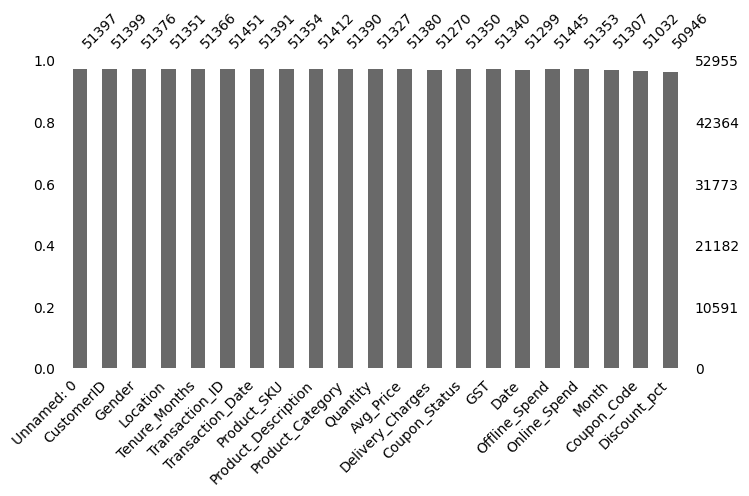

In [14]:
# The bar chart of missing values.

msno.bar(data, figsize=(8, 4), fontsize=10)

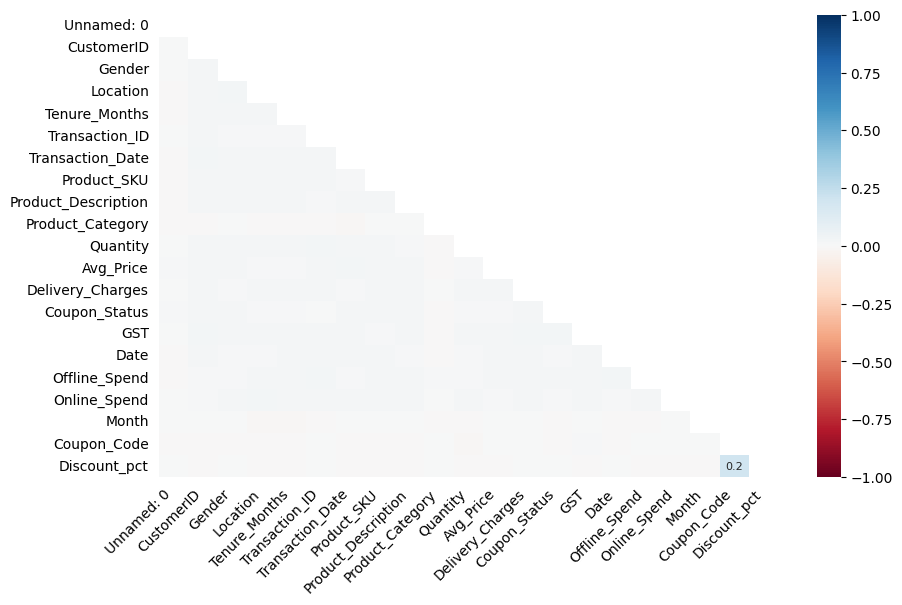

In [15]:
# Nullity Correlation (Heatmap)

msno.heatmap(df = data,
             figsize = (10, 6),
             fontsize = 10);

**2.2 Deleting and Filling Missing Data.**


* "Unnamed: 0" column has no relation to the data and is typically added as an index
* Rows with missing values in columns like "CustomerID, Location, Transaction_ID, Transaction_Date, Product_SKU, Date, Month" are removed due to their critical nature and high missing data percentage.
* Other columns will be filled with appropriate imputation methods (e.g., median, mode) to handle missing values.


In [16]:
# 1. Remove the "Unnamed: 0" column:
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

# 2. Delete rows containing missing values:
drop_cols = ['CustomerID', 'Location', 'Transaction_ID', 'Transaction_Date', 
             'Product_SKU', 'Date', 'Month']
data.dropna(subset=drop_cols, inplace=True)

# 3. Fill missing values appropriately:
data['Gender'].fillna('Unknown', inplace=True)
data['Product_Description'].fillna('Not Available', inplace=True)
data['Product_Category'].fillna('Unknown', inplace=True)
data['Coupon_Status'].fillna('Not Used', inplace=True)
data['Coupon_Code'].fillna('Not Used', inplace=True)

# Fill numerical columns with the median:
numeric_fill_cols = ['Tenure_Months', 'Quantity', 'Avg_Price', 
                     'Delivery_Charges', 'GST', 'Offline_Spend', 
                     'Online_Spend', 'Discount_pct']

for col in numeric_fill_cols:
    if col in data.columns:
        data[col].fillna(data[col].median(), inplace=True)

# Recheck missing values after filling.
missing_data = data.isnull().sum()
missing_percentage = (missing_data / len(data)) * 100
missing_table = pd.DataFrame({'Missing Values': missing_data,
                              'Percentage': missing_percentage})
print("The table after missing data processing:")
print(missing_table)

The table after missing data processing:
                     Missing Values  Percentage
CustomerID                        0         0.0
Gender                            0         0.0
Location                          0         0.0
Tenure_Months                     0         0.0
Transaction_ID                    0         0.0
Transaction_Date                  0         0.0
Product_SKU                       0         0.0
Product_Description               0         0.0
Product_Category                  0         0.0
Quantity                          0         0.0
Avg_Price                         0         0.0
Delivery_Charges                  0         0.0
Coupon_Status                     0         0.0
GST                               0         0.0
Date                              0         0.0
Offline_Spend                     0         0.0
Online_Spend                      0         0.0
Month                             0         0.0
Coupon_Code                       0         0.0

In [17]:
# The current state of the dataset.

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42903 entries, 0 to 52923
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           42903 non-null  float64
 1   Gender               42903 non-null  object 
 2   Location             42903 non-null  object 
 3   Tenure_Months        42903 non-null  float64
 4   Transaction_ID       42903 non-null  float64
 5   Transaction_Date     42903 non-null  object 
 6   Product_SKU          42903 non-null  object 
 7   Product_Description  42903 non-null  object 
 8   Product_Category     42903 non-null  object 
 9   Quantity             42903 non-null  float64
 10  Avg_Price            42903 non-null  float64
 11  Delivery_Charges     42903 non-null  float64
 12  Coupon_Status        42903 non-null  object 
 13  GST                  42903 non-null  float64
 14  Date                 42903 non-null  object 
 15  Offline_Spend        42903 non-null  floa

In [18]:
# Adding New Columns:
data['Total Prices'] = data['Avg_Price'] * data['Quantity'] + data['Delivery_Charges']
data['Total_Spend'] = data['Offline_Spend'] + data['Online_Spend']

# Analysis of total expenditures by month:
new = data[['Offline_Spend', 'Online_Spend', 'Month', 'Total_Spend']].groupby('Month').sum()

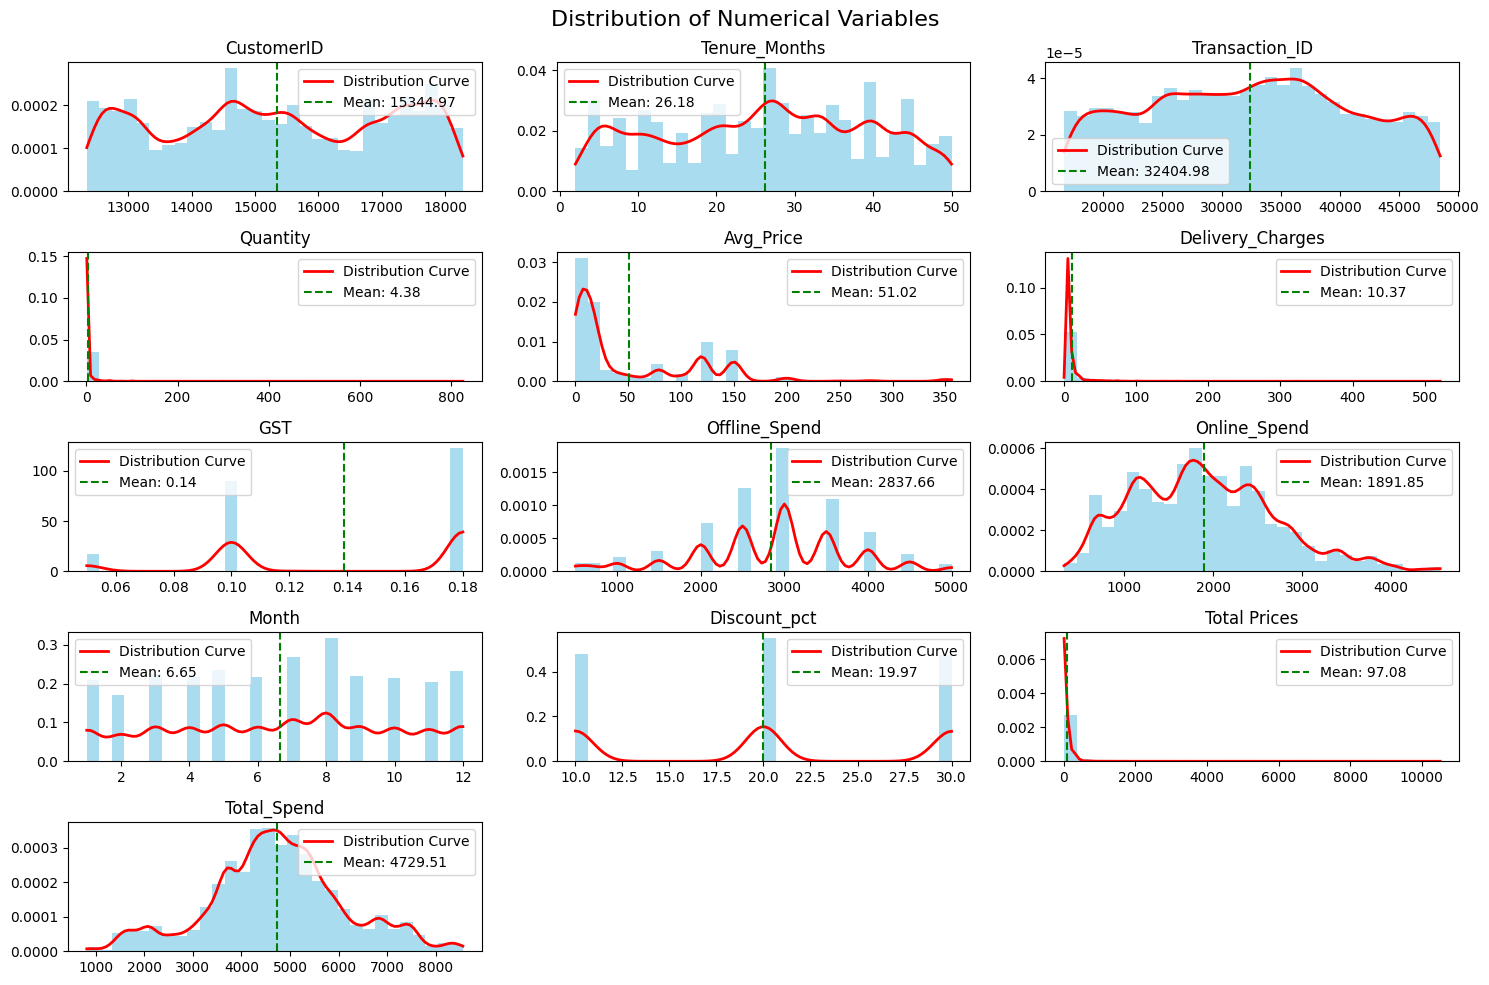

In [19]:
# Select numerical columns:
numeric_cols = data.select_dtypes(include=[np.number]).columns
numeric_data = data[numeric_cols]

# Calculate the number of subplots:
n_cols = len(numeric_cols)
n_rows = int(np.ceil(n_cols/3))

# Create the figure:
fig = plt.figure(figsize=(15, 10))

# Plot histogram and density curve for each variable:
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, 3, i)
    
    # Histogram
    plt.hist(numeric_data[col], bins=30, density=True, color='skyblue', 
              alpha=0.7)
    
    # Define the data range:
    x_range = np.linspace(numeric_data[col].min(), numeric_data[col].max(), 100)
    
    # Calculate and plot KDE (Kernel Density Estimation):
    kde = stats.gaussian_kde(numeric_data[col].dropna())
    plt.plot(x_range, kde(x_range), 'r-', lw=2, label='Distribution Curve')
    
    # Draw the mean line:
    mean_val = numeric_data[col].mean()
    plt.axvline(x=mean_val, color='green', linestyle='--', 
                label=f'Mean: {mean_val:.2f}')
    
    plt.title(col)
    plt.legend()

plt.suptitle('Distribution of Numerical Variables', fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
data.duplicated().sum()

0

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42903 entries, 0 to 52923
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           42903 non-null  float64
 1   Gender               42903 non-null  object 
 2   Location             42903 non-null  object 
 3   Tenure_Months        42903 non-null  float64
 4   Transaction_ID       42903 non-null  float64
 5   Transaction_Date     42903 non-null  object 
 6   Product_SKU          42903 non-null  object 
 7   Product_Description  42903 non-null  object 
 8   Product_Category     42903 non-null  object 
 9   Quantity             42903 non-null  float64
 10  Avg_Price            42903 non-null  float64
 11  Delivery_Charges     42903 non-null  float64
 12  Coupon_Status        42903 non-null  object 
 13  GST                  42903 non-null  float64
 14  Date                 42903 non-null  object 
 15  Offline_Spend        42903 non-null  floa

# 3. Categorical Data Analysis

In [22]:
mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

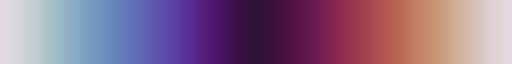

In [23]:
#We are creating a color palette for the graph using Matplotlib's 'Accent' and 'twilight' colormaps.

from matplotlib import cm
c1=cm.get_cmap('Accent')
c2=cm.get_cmap('twilight')
c2

Text(0.5, 0, 'Customer ID')

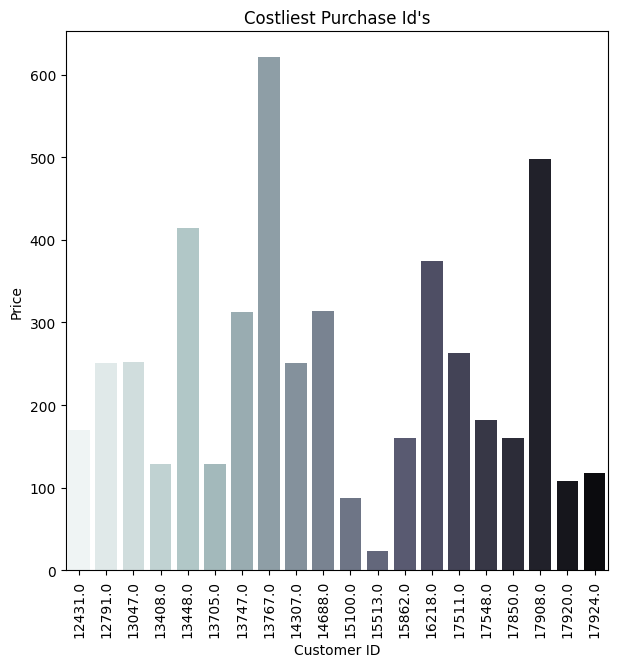

In [24]:
# A bar chart showing the top 20 customers with the most expensive purchases.

val1=data[['CustomerID','Total Prices']]
x=val1.CustomerID.unique()[:20]
y=val1['Total Prices'].unique()[:20]
fig,axis=plt.subplots(figsize=(7,7))

val1=val1.sort_values(by='Total Prices',ascending=False)
sb.barplot(x=x,y=y,palette='bone_r',ax=axis)
plt.xticks(rotation=90)
plt.title("Costliest Purchase Id's")
plt.ylabel('Price')
plt.xlabel('Customer ID')

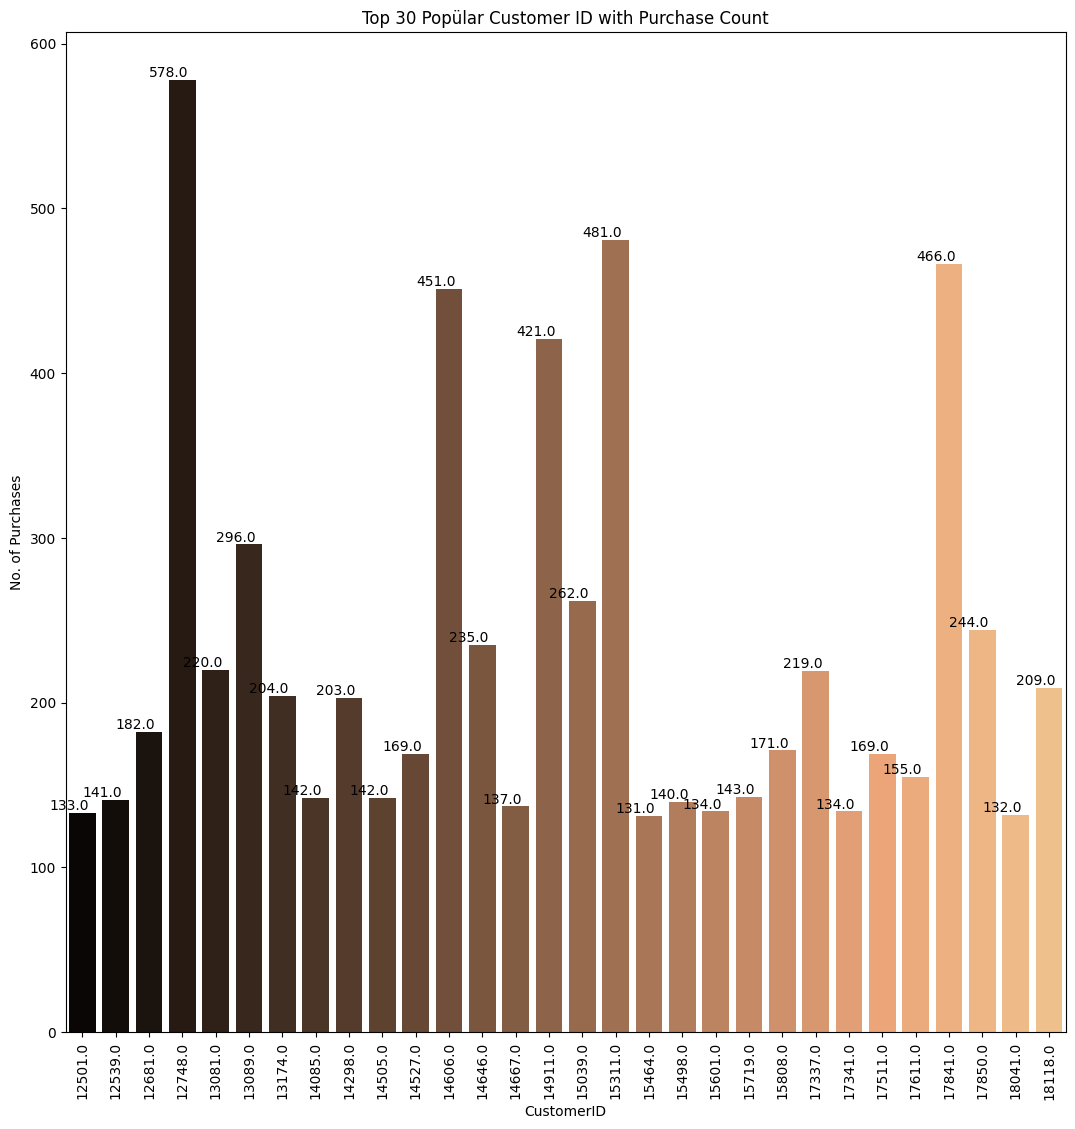

In [25]:
# A bar chart visualizing the number of purchases made by the top 30 customers with the highest purchase counts.

fig=plt.figure(figsize=(10,10))
axis=fig.add_axes([1,1,1,1])
val2=data.CustomerID.value_counts().sort_values(ascending=False).head(30)
sb.barplot(x=val2.index,y=val2,palette='copper',ax=axis)

plt.xticks(rotation=90)
plt.ylabel('No. of Purchases')
plt.title('Top 30 Popülar Customer ID with Purchase Count')
for i in axis.patches:
    axis.annotate(i.get_height(),(i.get_x(),i.get_height()),va='bottom',ha='center')

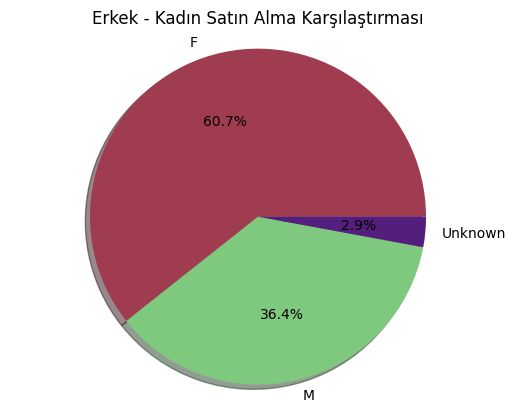

In [26]:
# Displaying the shopping percentages by gender using a pie chart.

# Get the gender values and their counts.
val3 = data['Gender'].value_counts()

explode = [0.1 if label == 'Female' else 0 for label in val3.index]

plt.pie(
    val3,
    labels=val3.index,
    autopct="%1.1f%%",
    shadow=True,
    explode=explode,
    colors=[c2(0.7), c1(0.1), c2(0.4)],
)
plt.axis('equal')
plt.title('Erkek - Kadın Satın Alma Karşılaştırması')
plt.show()


Text(47.097222222222214, 0.5, 'Percentages')

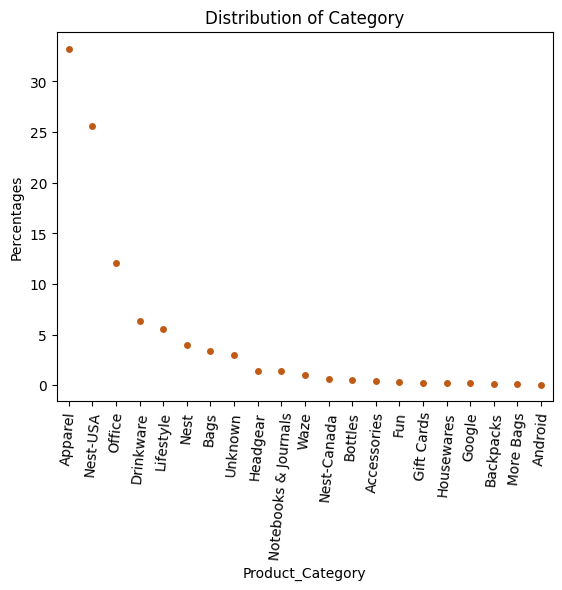

In [27]:
# Visualizing the percentage distribution of product categories using a swarm plot.

freqdata=data.Product_Category.value_counts()
total=freqdata.sum()
percent=(freqdata.values/total)*100
sb.swarmplot(x=freqdata.index,y=percent,color=c1(0.8))
plt.xticks(rotation=85)
plt.title('Distribution of Category')
plt.ylabel('Percentages')

Text(0.5, 1.0, 'Location Frequencies')

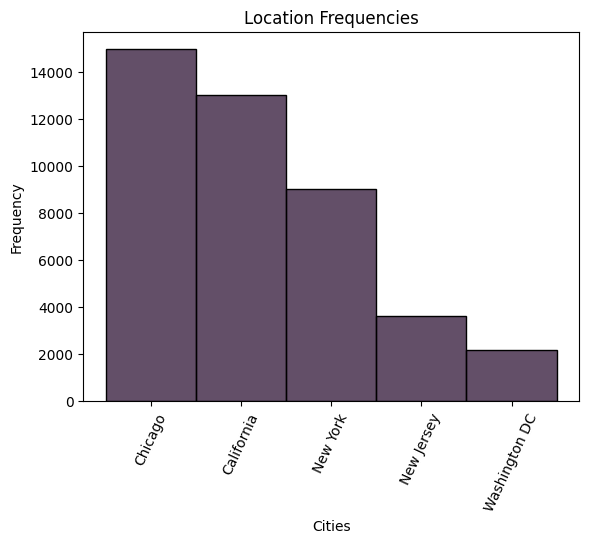

In [28]:
# Displaying the shopping frequency of cities using a histogram.

sb.histplot(data.Location,color=c2(0.5))
plt.ylabel('Frequency')
plt.xlabel('Cities')
plt.xticks(rotation=65)
plt.title('Location Frequencies')

Text(0.5, 1.0, 'Coupon_status')

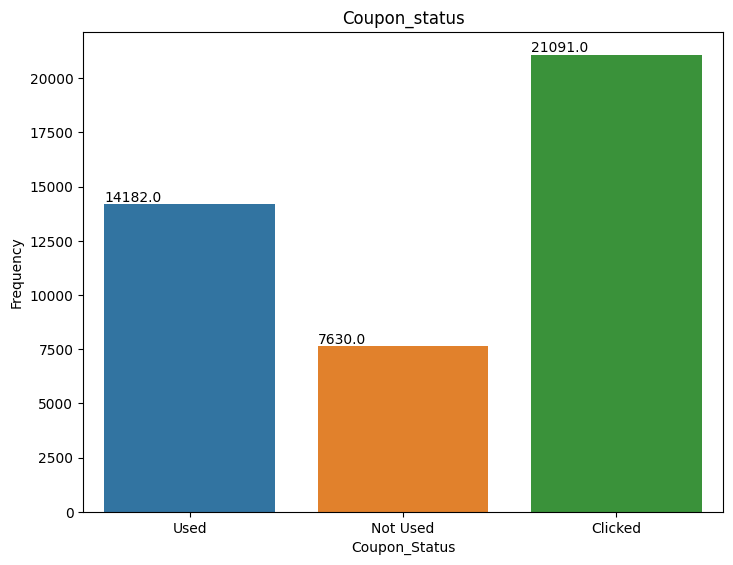

In [29]:
# Visualizing the coupon usage frequency using a bar chart.

fig=plt.figure()
axis=fig.add_axes([1,1,1,1])
nd1=data.Coupon_Status
sb.countplot(data=nd1,x=nd1,ax=axis)

for i in axis.patches:
    axis.annotate(i.get_height(),(i.get_x(),i.get_height()),va='bottom',ha='left')
plt.ylabel('Frequency')
plt.title('Coupon_status')

Text(0.5, 1.0, 'Delivery Charges Vs Avg_Price')

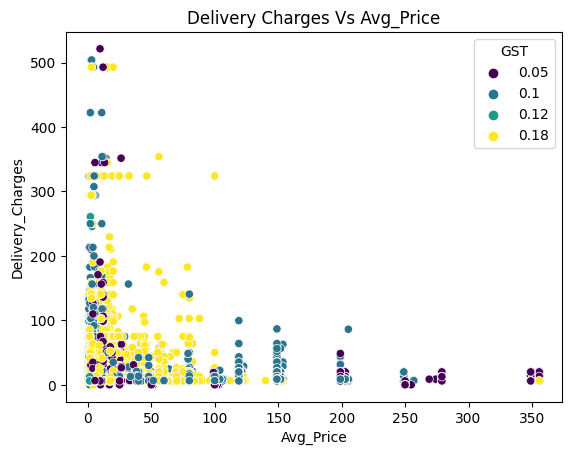

In [30]:
# Drawing a scatter plot to show the relationship between delivery fees and average price, with the points colored based on GST
sb.scatterplot(data=data,y='Delivery_Charges',x='Avg_Price',hue='GST',palette='viridis')
plt.title('Delivery Charges Vs Avg_Price')

# 4. Continuous Data Analysis

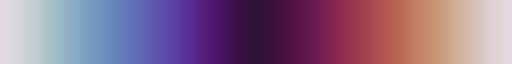

In [31]:
#We are creating a color palette for the graph using Matplotlib's 'Accent' and 'twilight' colormaps.

from matplotlib import cm
c1=cm.get_cmap('Accent')
c2=cm.get_cmap('twilight')
c2

Text(0.5, 1.0, 'Tenure Months Frequency of Customers')

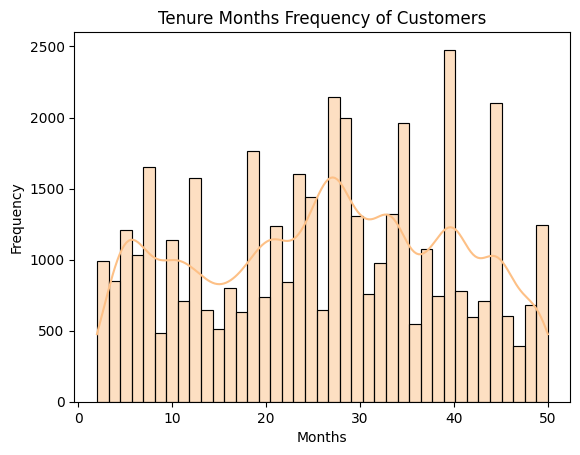

In [32]:
# A histogram showing the distribution and frequency of customers' monthly working hours.

val4=data.Tenure_Months
sb.histplot(val4,kde=True,color=c1(0.3))
plt.xlabel('Months')
plt.ylabel('Frequency')
plt.title('Tenure Months Frequency of Customers')

Text(0.5, 1.0, 'Heatmap')

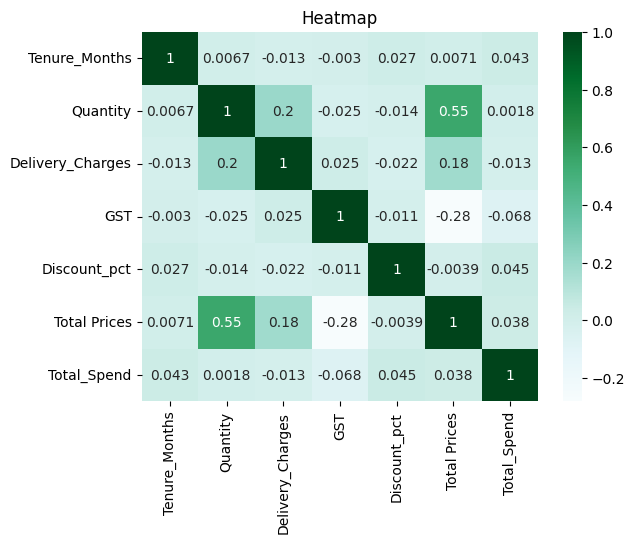

In [33]:
# Analyzing the correlation between data columns using a heatmap.

x=make_column_selector(dtype_include=['number'])
newdf=data[x(data)]
newdf.drop(['CustomerID','Transaction_ID','Online_Spend','Month','Offline_Spend','Avg_Price'],axis=1,inplace=True)
sb.heatmap(newdf.corr(),annot=True,cmap='BuGn')
plt.title('Heatmap')

Text(0.5, 1.0, 'Price Spend')

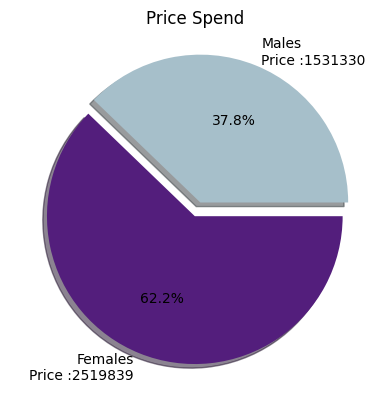

In [34]:
# Displaying the total spending amounts for men and women using a pie chart, which shows the proportion of spending for each gender.

male=data[['Total Prices','Gender']].groupby('Gender').get_group('M')['Total Prices'].sum()
female=data[['Total Prices','Gender']].groupby('Gender').get_group('F')['Total Prices'].sum()
sizes=[round(male),round(female)]
labels=['Males','Females']
plt.pie(sizes,autopct='%1.1f%%',labels=[f'{label}\nPrice :{size}' for label, size in zip(labels, sizes)],shadow=True,explode=(0.1,0),colors=[c2(0.1),c2(0.4)])
plt.title('Price Spend')

In [35]:
nd2=data[['Total Prices','Gender','Location']].groupby('Location')
nd3=[]
nd4=[]
for i in data.Location.unique():
    nd3.append((round(nd2.get_group(i)['Total Prices'].sum()),i))

In [36]:
y=list(map(lambda x :x[0],nd3))
x=list(map(lambda x :x[1],nd3))

Text(0.5, 1.0, 'Cities with Price Spent')

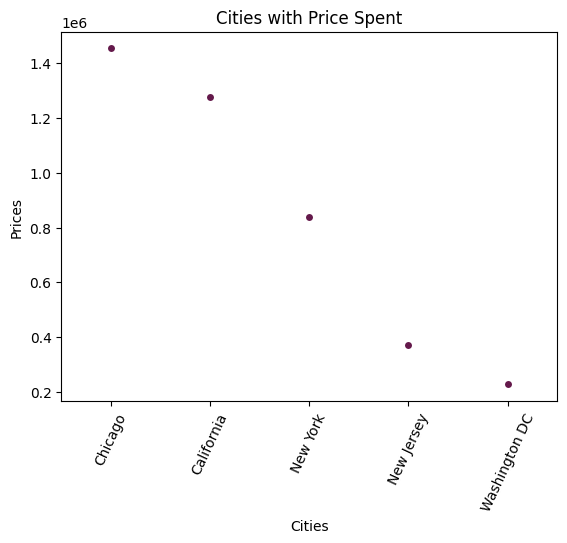

In [37]:
# Visualizing the total spending by cities using a swarm plot.

sb.swarmplot(x=x,y=y,color=c2(0.6))
plt.xlabel('Cities')
plt.ylabel('Prices')
plt.xticks(rotation=65)
plt.title('Cities with Price Spent')

# 5. Time Series Analysis

Text(0.5, 1.0, 'Total Spend With Month')

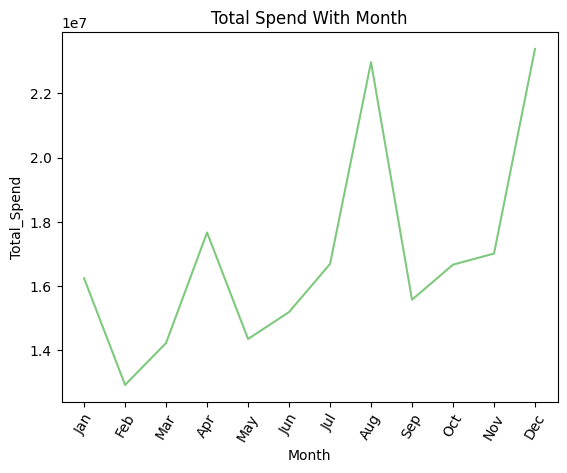

In [38]:
# Visualizing the total spending by month using a line chart, with the month names displayed on the x-axis.
sb.lineplot(y=new.Total_Spend,x=new.index,color=c1(0.1))
plt.xticks(new.index,mon,rotation=60)
plt.title("Total Spend With Month")

Text(0.5, 1.0, 'Total Online Spend With Month')

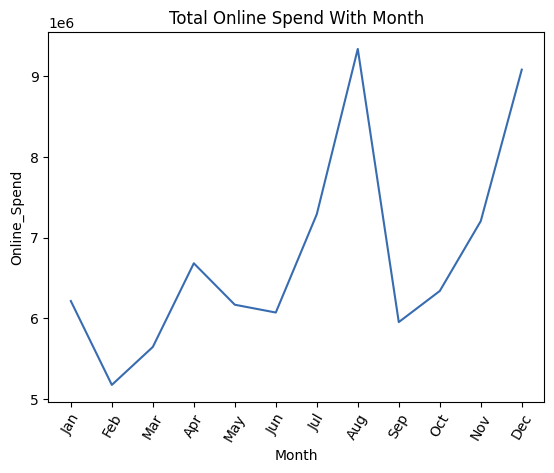

In [39]:
# Visualizing the total online spending by month using a line chart, with the month names shown on the x-axis.
sb.lineplot(y=new.Online_Spend,x=new.index,color=c1(0.5))
plt.xticks(new.index,mon,rotation=60)
plt.title("Total Online Spend With Month")

Text(0.5, 1.0, 'Total Offline Spend With Month')

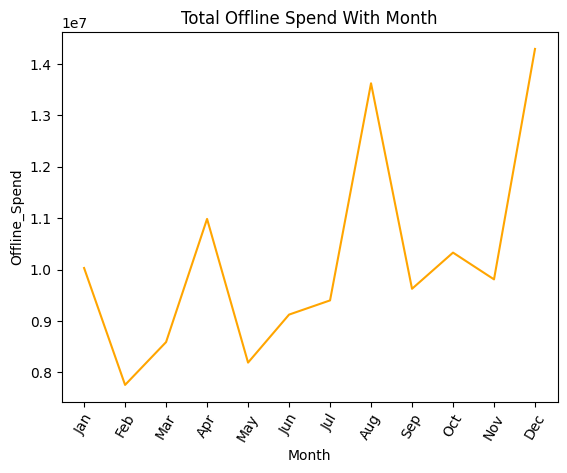

In [40]:
# Visualizing the total offline spending by month using a line chart, with the month names displayed on the x-axis.
sb.lineplot(y=new.Offline_Spend,x=new.index,color='orange')
plt.xticks(new.index,mon,rotation=60)
plt.title("Total Offline Spend With Month")

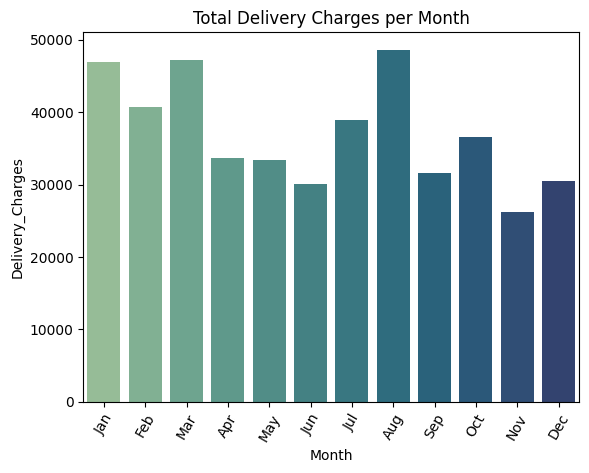

In [41]:
# A graph showing the total delivery fees for each month.

delivery = data[['Delivery_Charges', 'Month']].groupby('Month').sum()
sb.barplot(data=delivery.reset_index(), x='Month', y='Delivery_Charges', palette='crest')

plt.xticks(range(12), mon, rotation=60)
plt.title("Total Delivery Charges per Month")
plt.show()
